# Gaussian Process Regression Testing

In this notebook I want to compare python implementations of Gaussian Process regression in 3D with the Scalismo library written in Scala

Two methods will be used: 
- Sklearn https://scikit-learn.org/stable/modules/generated/sklearn.gaussian_process.GaussianProcessRegressor.html 
- GPyTorch https://docs.gpytorch.ai/en/stable/index.html 

While the Sklearn implementation is simpler (and maybe more flexible), the GPy

In [1]:
import time
import numpy as np
import ipytest
import torch 
import gpytorch
import matplotlib.pyplot as plt

from tqdm import tqdm

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel

from typing import Union

In [2]:
ipytest.autoconfig(raise_on_error=True)
print("Using PyTorch", torch.__version__, "and GPyTorch", gpytorch.__version__)
torch.backends.cudnn.enabled, torch.cuda.is_available()

Using PyTorch 2.4.0+cu121 and GPyTorch 1.12


(True, True)

In [3]:
def vectorize(data: Union[np.ndarray, torch.Tensor]) -> Union[np.ndarray, torch.Tensor]:
  if isinstance(data, np.ndarray):
      return data.flatten()
  elif isinstance(data, torch.Tensor):
      return data.view(-1)
  else:
      raise TypeError("Input must be either a numpy array or a PyTorch tensor")

def unvectorize(data: Union[np.ndarray, torch.Tensor], dim: int) -> Union[np.ndarray, torch.Tensor]:
  if isinstance(data, np.ndarray):
      n = int(len(data)/dim)
      return data.reshape((n, dim))
  elif isinstance(data, torch.Tensor):
      n = int(data.numel()/dim)
      return data.view(n, dim)
  else:
      raise TypeError("Input must be either a numpy array or a PyTorch tensor")


In [4]:
%%ipytest -s
# | code-fold: true

def test_vectorize():
    input_data = torch.tensor([[1, 2, 3], [4, 5, 6]])
    expected_output = torch.tensor([1, 2, 3, 4, 5, 6])
    assert torch.all(vectorize(input_data).eq(expected_output))
    assert np.array_equal(vectorize(input_data).numpy(), expected_output.numpy())

def test_unvectorize():
    input_data = torch.tensor([1, 2, 3, 4, 5, 6])
    expected_output = torch.tensor([[1, 2, 3], [4, 5, 6]])
    assert torch.all(unvectorize(input_data, 3).eq(expected_output))
    assert np.array_equal(unvectorize(input_data.numpy(), 3), expected_output.numpy())

def vectorize_unvectorize_roundtrip(data: Union[np.ndarray, torch.Tensor]) -> bool:
    vectorized = vectorize(data)
    unvectorized = unvectorize(vectorized, data.shape[1])
    if isinstance(data, torch.Tensor):
        return torch.all(data.eq(unvectorized))
    else:
        return np.array_equal(data, unvectorized)

def test_vectorize_unvectorize_roundtrip():
    input_data = torch.tensor([[1.0, 2.0, 3.0], [4.0, 5.0, 6.0], [7.0, 8.0, 9.0]])
    assert vectorize_unvectorize_roundtrip(input_data)
    assert vectorize_unvectorize_roundtrip(input_data.numpy())

    random_data = torch.rand(10, 5)
    assert vectorize_unvectorize_roundtrip(random_data)
    assert vectorize_unvectorize_roundtrip(random_data.numpy())

...
========================================= warnings summary =========================================
../../../../../home/dennis/miniconda3/envs/mynotebooks/lib/python3.10/site-packages/_pytest/config/__init__.py:1273
  /home/dennis/miniconda3/envs/mynotebooks/lib/python3.10/site-packages/_pytest/config/__init__.py:1273: PytestAssertRewriteWarning: Module already imported so cannot be rewritten: jaxtyping
    self._mark_plugins_for_rewrite(hook)

-- Docs: https://docs.pytest.org/en/stable/how-to/capture-warnings.html
3 passed, 1 warning in 0.01s


# Sklearn example in 3D - i.e. no vetorization of data

In [5]:
plot_data = True
board_size = 100
if plot_data:
    board_size = 20
num_points = board_size*board_size

noise_levels = [1.0]
if plot_data:
    noise_levels = [1.0, 2.0, 5.0]

z_pos = board_size/2.0 #0.0
i, j = np.indices((board_size, board_size))
points = np.stack((i, j, np.ones_like(i) * z_pos), axis=-1).reshape(-1, 3)

print(f"Total number of points: {int(points.size/3):,}")

def plot_3d(ax, X, Y, Z, title):
    # zs = np.zeros(num_points) 
    # dx = np.ones(num_points) 
    # dy = np.ones(num_points) 
    # ax.bar3d(X, Y, zs, dx, dy, Z)
    ax.scatter(X, Y, Z)
    ax.set_title(title)
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.set_xlim([0, board_size])
    ax.set_ylim([0, board_size])
    ax.set_zlim([0, board_size])

pos_points = [points[0], points[int(board_size**2/2-board_size/2)]]

deformation_vector = np.array([0, 0, board_size])
deformation_point_0 = np.array(pos_points[0])
deformation_point_1 = np.array(pos_points[1])

X = np.array([deformation_point_0, deformation_point_1])
y = np.array([deformation_vector, deformation_vector])

kernel_rbf = RBF(length_scale=1.0) #+ WhiteKernel(noise_level=1.0)

Total number of points: 400


Calling fit
Calling predict
Execution time posterior: 0.01s with noise: 1.0
Execution time adding: 0.00s with noise: 1.0
Calling fit
Calling predict
Execution time posterior: 0.01s with noise: 2.0
Execution time adding: 0.00s with noise: 2.0
Calling fit
Calling predict
Execution time posterior: 0.01s with noise: 5.0
Execution time adding: 0.00s with noise: 5.0


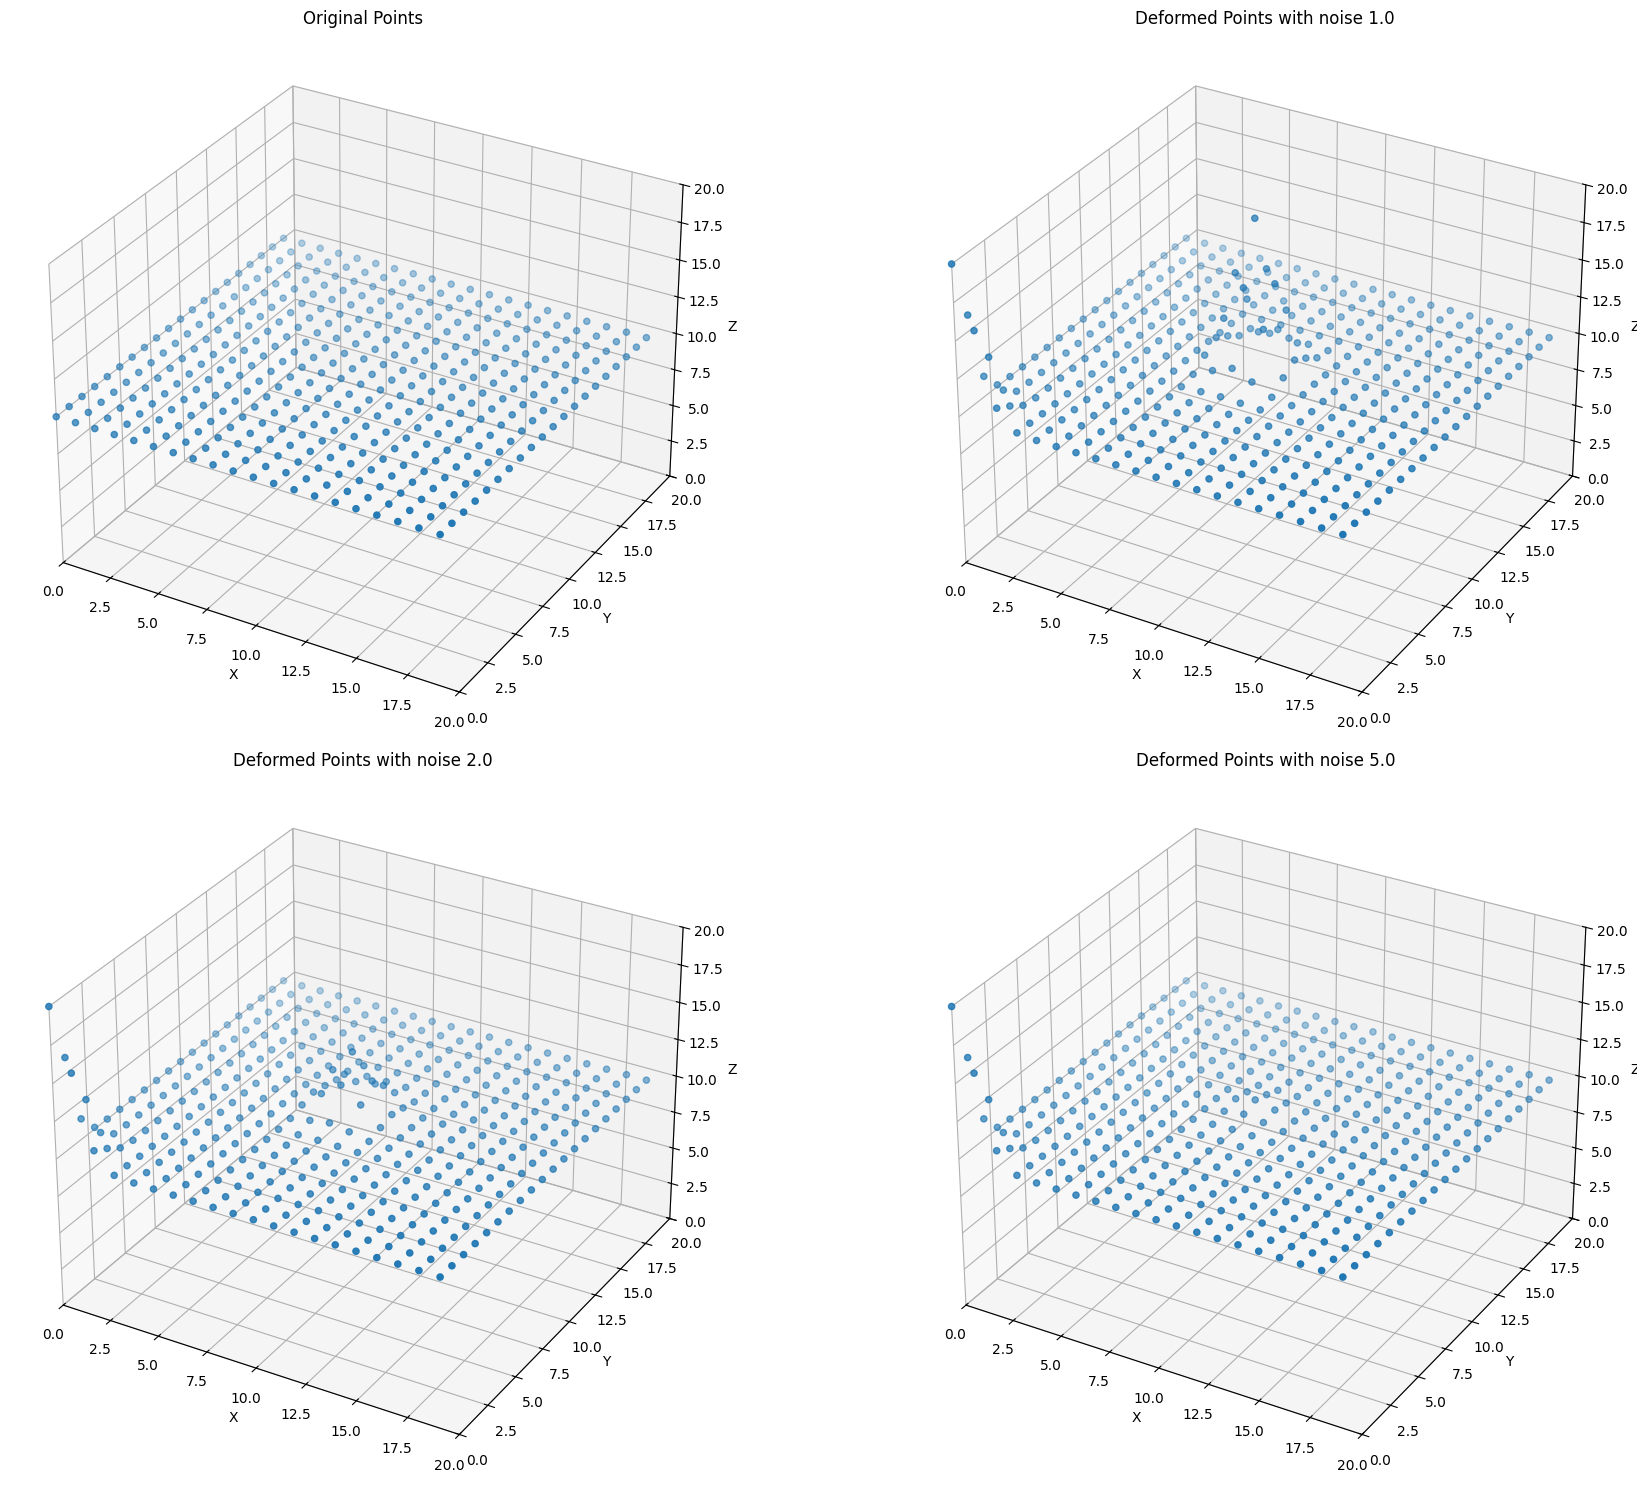

In [6]:
if plot_data:
    fig = plt.figure(figsize=(20, 15))
    ax = fig.add_subplot(2,2,1, projection='3d')
    plot_3d(ax, points[:, 0], points[:, 1], points[:, 2], "Original Points")

for i, noise in enumerate(noise_levels):

    gpr = GaussianProcessRegressor(kernel=kernel_rbf, alpha=np.array([1.0, noise**2]))

    start_time = time.time()
    print("Calling fit")
    gpr.fit(X, y)
    print("Calling predict")
    predicted_deformation_field = gpr.predict(points)
    
    mid_time = time.time()
    new_points = points + predicted_deformation_field

    end_time = time.time()
    execution_time_pos = mid_time - start_time
    execution_time_add = end_time - mid_time
    print(f"Execution time posterior: {execution_time_pos:.2f}s with noise: {noise}")
    print(f"Execution time adding: {execution_time_add:.2f}s with noise: {noise}")

    if plot_data:
        ax = fig.add_subplot(2,2,i+2, projection='3d')
        plot_3d(ax, new_points[:, 0], new_points[:, 1], new_points[:, 2], f"Deformed Points with noise {noise}")

if plot_data:
    plt.tight_layout()
    plt.show()

# Simple 1D example with variable noise terms in Gpytorch
- Using Multitask model but with num_task=1 (such that it is similar to using a standard MultivariateNormal

In [7]:
train_x = torch.tensor([0.01, 0.3, 0.6, 0.99]).unsqueeze(-1)
train_y = torch.tensor([1.0, -2.0, 2.0, -4.0]).unsqueeze(-1)
observation_noise = torch.tensor([1.0, 0.0001, 5.0, 0.1])

# Simple 1D example
# class ExactGPModel(gpytorch.models.ExactGP):
#     def __init__(self, train_x, train_y, likelihood):
#         super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
#         self.kernel = gpytorch.kernels.RBFKernel()
#         self.kernel.lengthscale = 1.0
#         self.mean_module = gpytorch.means.ZeroMean()
#         self.covar_module = gpytorch.kernels.ScaleKernel(self.kernel)
#         self.covar_module.outputscale = 1.0
    
#     def forward(self, x):
#         mean_x = self.mean_module(x)
#         covar_x = self.covar_module(x)
#         return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)
    
# Multi-task GP example with 1D input/output
class MultitaskExactGPModel(gpytorch.models.ExactGP):
  def __init__(self, train_x, train_y, likelihood):
      super(MultitaskExactGPModel, self).__init__(train_x, train_y, likelihood)
      
      self.num_tasks = 1
      
      self.base_kernel = gpytorch.kernels.RBFKernel()
      self.base_kernel.lengthscale = 1.0
      
      self.covar_module = gpytorch.kernels.MultitaskKernel(
          self.base_kernel, num_tasks=self.num_tasks, rank=1
      )
      self.covar_module.outputscale = 1.0
      
      self.mean_module = gpytorch.means.MultitaskMean(
          gpytorch.means.ZeroMean(), num_tasks=self.num_tasks
      )

  def forward(self, x):
      mean_x = self.mean_module(x)
      covar_x = self.covar_module(x)
      return gpytorch.distributions.MultitaskMultivariateNormal(mean_x, covar_x)

In [8]:
# initialize likelihood and model
likelihood = gpytorch.likelihoods.FixedNoiseGaussianLikelihood(noise=observation_noise, learn_additional_noise=False)
model = MultitaskExactGPModel(train_x, train_y, likelihood)
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)  # Includes GaussianLikelihood parameters
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

training_iter = 50

pbar = tqdm(range(training_iter), desc="Training")

model.train()
likelihood.train()
for _ in pbar:
    # Zero gradients from previous iteration
    optimizer.zero_grad()
    # Output from model
    output = model(train_x)
    # Calc loss and backprop gradients
    loss = -mll(output, train_y)
    loss.backward()
    pbar.set_description(f"Loss: {loss.item():.3f}, Noise: {noise}")
    optimizer.step()

Training:   0%|          | 0/50 [00:00<?, ?it/s]/home/dennis/miniconda3/envs/mynotebooks/lib/python3.10/site-packages/gpytorch/likelihoods/gaussian_likelihood.py:347: GPInputWarning: You have passed data through a FixedNoiseGaussianLikelihood that did not match the size of the fixed noise, *and* you did not specify noise. This is treated as a no-op.
  warnings.warn(
Loss: 9.329, Noise: 5.0: 100%|██████████| 50/50 [00:00<00:00, 195.82it/s] 


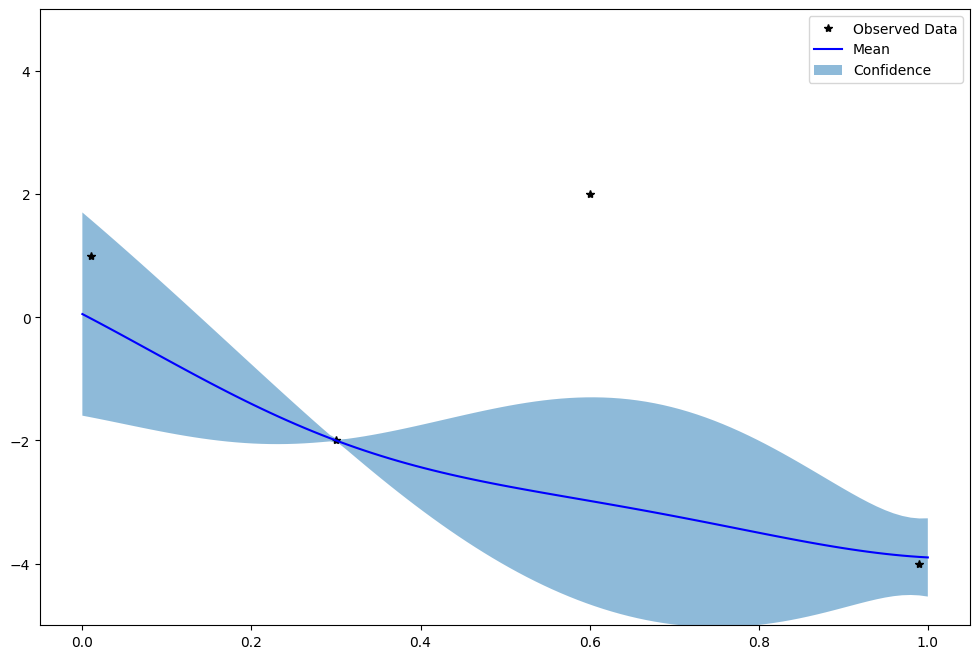

In [9]:
model.eval()
likelihood.eval()

with torch.no_grad(), gpytorch.settings.fast_pred_var():
    test_x = torch.linspace(0, 1, 100)
    observed_pred = likelihood(model(test_x))

with torch.no_grad():
    f, ax = plt.subplots(1, 1, figsize=(12, 8))

    lower, upper = observed_pred.confidence_region()
    lower = lower.squeeze().numpy()
    upper = upper.squeeze().numpy()
    ax.plot(train_x.numpy(), train_y.numpy(), 'k*')
    ax.plot(test_x.numpy(), observed_pred.mean.numpy(), 'b')
    ax.fill_between(test_x.numpy(), lower, upper, alpha=0.5)
    ax.set_ylim([-5, 5])
    ax.legend(['Observed Data', 'Mean', 'Confidence'])


# 3D Test

In [10]:
import torch
import gpytorch
from tqdm.notebook import tqdm

# GPYTORCH paper from 2018 (NeurIPS) https://arxiv.org/pdf/1809.11165 

class MultitaskGPModel(gpytorch.models.ExactGP):
  def __init__(self, train_x, train_y, likelihood):
      super(MultitaskGPModel, self).__init__(train_x, train_y, likelihood)
      self.mean_module = gpytorch.means.MultitaskMean(
          gpytorch.means.ZeroMean(), num_tasks=3
      )
      self.covar_module = gpytorch.kernels.MultitaskKernel(
          gpytorch.kernels.RBFKernel(), num_tasks=3, rank=0
      )

  def forward(self, x):
      mean_x = self.mean_module(x)
      covar_x = self.covar_module(x)
      return gpytorch.distributions.MultitaskMultivariateNormal(mean_x, covar_x)

device = "cpu" # torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Convert numpy arrays to PyTorch tensors
points_tensor = torch.tensor(points, dtype=torch.float32).to(device)

Using device: cpu


In [93]:
from typing import Any, Optional, Union

import torch
from linear_operator import to_linear_operator
from linear_operator.operators import (
    ConstantDiagLinearOperator,
    DiagLinearOperator,
    KroneckerProductDiagLinearOperator,
    KroneckerProductLinearOperator,
    LinearOperator,
    RootLinearOperator,
)
from torch import Tensor
from torch.distributions import Normal

from gpytorch.constraints import GreaterThan, Interval
from gpytorch.distributions import base_distributions, MultitaskMultivariateNormal
from gpytorch.lazy import LazyEvaluatedKernelTensor
from gpytorch.likelihoods import _GaussianLikelihoodBase, Likelihood
from gpytorch.priors import Prior
from gpytorch.likelihoods.noise_models import FixedGaussianNoise, Noise


class _MyMultitaskGaussianLikelihoodBase(_GaussianLikelihoodBase):
    r"""
    Base class for multi-task Gaussian Likelihoods, supporting general heteroskedastic noise models.

    :param num_tasks: Number of tasks.
    :param noise_covar: A model for the noise covariance. This can be a simple homoskedastic noise model, or a GP
        that is to be fitted on the observed measurement errors.
    :param rank: The rank of the task noise covariance matrix to fit. If `rank`
        is set to 0, then a diagonal covariance matrix is fit.
    :param task_correlation_prior: Prior to use over the task noise correlation
        matrix. Only used when :math:`\text{rank} > 0`.
    :param batch_shape: Number of batches.
    """

    def __init__(
        self,
        num_tasks: int,
        noise_covar: Union[Noise, FixedGaussianNoise],
        rank: int = 0,
        task_correlation_prior: Optional[Prior] = None,
        batch_shape: torch.Size = torch.Size(),
    ) -> None:
        super().__init__(noise_covar=noise_covar)
        if rank != 0:
            if rank > num_tasks:
                raise ValueError(f"Cannot have rank ({rank}) greater than num_tasks ({num_tasks})")
            tidcs = torch.tril_indices(num_tasks, rank, dtype=torch.long)
            self.tidcs: Tensor = tidcs[:, 1:]  # (1, 1) must be 1.0, no need to parameterize this
            task_noise_corr = torch.randn(*batch_shape, self.tidcs.size(-1))
            self.register_parameter("task_noise_corr", torch.nn.Parameter(task_noise_corr))
            if task_correlation_prior is not None:
                self.register_prior(
                    "MultitaskErrorCorrelationPrior", task_correlation_prior, lambda m: m._eval_corr_matrix
                )
        elif task_correlation_prior is not None:
            raise ValueError("Can only specify task_correlation_prior if rank>0")
        self.num_tasks = num_tasks
        self.rank = rank

    def _eval_corr_matrix(self) -> Tensor:
        tnc = self.task_noise_corr
        fac_diag = torch.ones(*tnc.shape[:-1], self.num_tasks, device=tnc.device, dtype=tnc.dtype)
        Cfac = torch.diag_embed(fac_diag)
        Cfac[..., self.tidcs[0], self.tidcs[1]] = self.task_noise_corr
        # squared rows must sum to one for this to be a correlation matrix
        C = Cfac / Cfac.pow(2).sum(dim=-1, keepdim=True).sqrt()
        return C @ C.transpose(-1, -2)

    def marginal(
        self, function_dist: MultitaskMultivariateNormal, *params: Any, **kwargs: Any
    ) -> MultitaskMultivariateNormal:  # pyre-ignore[14]
        r"""
        If :math:`\text{rank} = 0`, adds the task noises to the diagonal of the
        covariance matrix of the supplied
        :obj:`~gpytorch.distributions.MultivariateNormal` or
        :obj:`~gpytorch.distributions.MultitaskMultivariateNormal`.  Otherwise,
        adds a rank `rank` covariance matrix to it.

        To accomplish this, we form a new
        :obj:`~linear_operator.operators.KroneckerProductLinearOperator`
        between :math:`I_{n}`, an identity matrix with size equal to the data
        and a (not necessarily diagonal) matrix containing the task noises
        :math:`D_{t}`.

        We also incorporate a shared `noise` parameter from the base
        :class:`gpytorch.likelihoods.GaussianLikelihood` that we extend.

        The final covariance matrix after this method is then
        :math:`\mathbf K + \mathbf D_{t} \otimes \mathbf I_{n} + \sigma^{2} \mathbf I_{nt}`.

        :param function_dist: Random variable whose covariance
            matrix is a :obj:`~linear_operator.operators.LinearOperator` we intend to augment.
        :rtype: `gpytorch.distributions.MultitaskMultivariateNormal`:
        :return: A new random variable whose covariance matrix is a
            :obj:`~linear_operator.operators.LinearOperator` with
            :math:`\mathbf D_{t} \otimes \mathbf I_{n}` and :math:`\sigma^{2} \mathbf I_{nt}` added.
        """
        mean, covar = function_dist.mean, function_dist.lazy_covariance_matrix

        # ensure that sumKroneckerLT is actually called
        if isinstance(covar, LazyEvaluatedKernelTensor):
            covar = covar.evaluate_kernel()

        covar_kron_lt = self._shaped_noise_covar(
            mean.shape, add_noise=self.has_global_noise, interleaved=function_dist._interleaved
        )
        covar = covar + covar_kron_lt

        return function_dist.__class__(mean, covar, interleaved=function_dist._interleaved)

    def _shaped_noise_covar(
        self, shape: torch.Size, add_noise: Optional[bool] = True, interleaved: bool = True, *params: Any, **kwargs: Any
    ) -> LinearOperator:
        dtype = self.raw_noise.dtype if self.has_global_noise else torch.float32
        device = self.raw_noise.device if self.has_global_noise else torch.device('cpu')

        if not self.has_task_noise and not self.has_independent_noise:
            noise = ConstantDiagLinearOperator(self.noise, diag_shape=shape[-2] * self.num_tasks)
            return noise
        

        if self.has_task_noise:
            if self.rank == 0:
                task_noises = self.raw_task_noises_constraint.transform(self.raw_task_noises)
                task_var_lt = DiagLinearOperator(task_noises)
                dtype, device = task_noises.dtype, task_noises.device
                ckl_init = KroneckerProductDiagLinearOperator
            else:
                task_noise_covar_factor = self.task_noise_covar_factor
                task_var_lt = RootLinearOperator(task_noise_covar_factor)
                dtype, device = task_noise_covar_factor.dtype, task_noise_covar_factor.device
                ckl_init = KroneckerProductLinearOperator

            eye_lt = ConstantDiagLinearOperator(
                torch.ones(*shape[:-2], 1, dtype=dtype, device=device), diag_shape=shape[-2]
            )
            task_var_lt = task_var_lt.expand(*shape[:-2], *task_var_lt.matrix_shape)  # pyre-ignore[6]

            if add_noise and self.has_global_noise:
                noise = ConstantDiagLinearOperator(self.noise, diag_shape=task_var_lt.shape[-1])
                task_var_lt = task_var_lt + noise

            if interleaved:
                covar_kron_lt = ckl_init(eye_lt, task_var_lt)
        else:
            # If there's no task noise, create an identity covariance
            eye_lt = ConstantDiagLinearOperator(
                torch.ones(*shape[:-2], 1, dtype=dtype, device=device), diag_shape=shape[-2] * self.num_tasks
            )
            covar_kron_lt = eye_lt

        if self.has_independent_noise:
            independent_noise = self.independent_noise

            # Ensure independent_noise has the correct shape
            if independent_noise.shape[0] < shape[-2]:
                independent_noise = independent_noise.expand(shape[-2])
            elif independent_noise.shape[0] > shape[-2]:
                independent_noise = independent_noise[:shape[-2]]

            if interleaved:
                independent_noise = independent_noise.repeat_interleave(self.num_tasks)
            else:
                independent_noise = independent_noise.repeat(self.num_tasks, 1).t().reshape(-1)
            
            covar_kron_lt = covar_kron_lt * DiagLinearOperator(independent_noise)

        return covar_kron_lt


    # def forward(self, function_samples: Tensor, *params: Any, **kwargs: Any) -> Normal:
    #     noise = self._shaped_noise_covar(function_samples.shape, *params, **kwargs).diagonal(dim1=-1, dim2=-2)
    #     noise = noise.reshape(*noise.shape[:-1], *function_samples.shape[-2:])
    #     if self.has_independent_noise:
    #         independent_noise = self.independent_noise_scale.expand(*function_samples.shape[:-1], 1)
    #         noise = noise * independent_noise
    #     return base_distributions.Independent(base_distributions.Normal(function_samples, noise.sqrt()), 1)
    
    def forward(self, function_samples: Tensor, *params: Any, **kwargs: Any) -> Normal:
        noise = self._shaped_noise_covar(function_samples.shape, *params, **kwargs).diagonal(dim1=-1, dim2=-2)
        noise = noise.reshape(*noise.shape[:-1], *function_samples.shape[-2:])
        return base_distributions.Independent(base_distributions.Normal(function_samples, noise.sqrt()), 1)


class MyMultitaskGaussianLikelihood(_MyMultitaskGaussianLikelihoodBase):
    r"""
    A convenient extension of the :class:`~gpytorch.likelihoods.GaussianLikelihood` to the multitask setting that allows
    for a full cross-task covariance structure for the noise. The fitted covariance matrix has rank `rank`.
    If a strictly diagonal task noise covariance matrix is desired, then rank=0 should be set. (This option still
    allows for a different `noise` parameter for each task.)

    Like the Gaussian likelihood, this object can be used with exact inference.

    .. note::
        At least one of :attr:`has_global_noise` or :attr:`has_task_noise` should be specified.

    .. note::
        MultittaskGaussianLikelihood has an analytic marginal distribution.

    :param num_tasks: Number of tasks.
    :param noise_covar: A model for the noise covariance. This can be a simple homoskedastic noise model, or a GP
        that is to be fitted on the observed measurement errors.
    :param rank: The rank of the task noise covariance matrix to fit. If `rank`
        is set to 0, then a diagonal covariance matrix is fit.
    :param task_prior: Prior to use over the task noise correlation
        matrix. Only used when :math:`\text{rank} > 0`.
    :param batch_shape: Number of batches.
    :param has_global_noise: Whether to include a :math:`\sigma^2 \mathbf I_{nt}` term in the noise model.
    :param has_task_noise: Whether to include task-specific noise terms, which add
        :math:`\mathbf I_n \otimes \mathbf D_T` into the noise model.

    :ivar torch.Tensor task_noise_covar: The inter-task noise covariance matrix
    :ivar torch.Tensor task_noises: (Optional) task specific noise variances (added onto the `task_noise_covar`)
    :ivar torch.Tensor noise: (Optional) global noise variance (added onto the `task_noise_covar`)
    """

    def __init__(
        self,
        num_tasks: int,
        rank: int = 0,
        batch_shape: torch.Size = torch.Size(),
        task_prior: Optional[Prior] = None,
        noise_prior: Optional[Prior] = None,
        noise_constraint: Optional[Interval] = None,
        has_global_noise: bool = True,
        has_task_noise: bool = True,
        has_independent_noise: bool = False,
    ) -> None:
        super(Likelihood, self).__init__()
        if noise_constraint is None:
            noise_constraint = GreaterThan(1e-4)

        if not has_task_noise and not has_global_noise and not has_independent_noise:
            raise ValueError(
                "At least one of has_task_noise, has_global_noise, or has_independent_noise must be specified."
            )

        if has_independent_noise:
            self.register_parameter(name="raw_independent_noise", parameter=torch.nn.Parameter(torch.zeros(1)))
            self.register_constraint("raw_independent_noise", noise_constraint)
       
        if has_task_noise:
            if rank == 0:
                self.register_parameter(
                    name="raw_task_noises", parameter=torch.nn.Parameter(torch.zeros(*batch_shape, num_tasks))
                )
                self.register_constraint("raw_task_noises", noise_constraint)
                if noise_prior is not None:
                    self.register_prior("raw_task_noises_prior", noise_prior, lambda m: m.task_noises)
                if task_prior is not None:
                    raise RuntimeError("Cannot set a `task_prior` if rank=0")
            else:
                self.register_parameter(
                    name="task_noise_covar_factor",
                    parameter=torch.nn.Parameter(torch.randn(*batch_shape, num_tasks, rank)),
                )
                if task_prior is not None:
                    self.register_prior("MultitaskErrorCovariancePrior", task_prior, lambda m: m._eval_covar_matrix)
        self.num_tasks = num_tasks
        self.rank = rank

        if has_global_noise:
            self.register_parameter(name="raw_noise", parameter=torch.nn.Parameter(torch.zeros(*batch_shape, 1)))
            self.register_constraint("raw_noise", noise_constraint)
            if noise_prior is not None:
                self.register_prior("raw_noise_prior", noise_prior, lambda m: m.noise)

        self.has_global_noise = has_global_noise
        self.has_task_noise = has_task_noise
        self.has_independent_noise = has_independent_noise
    
    @property
    def independent_noise(self) -> Optional[Tensor]:
        if self.has_independent_noise:
            return self.raw_independent_noise_constraint.transform(self.raw_independent_noise)
        return None

    @independent_noise.setter
    def independent_noise(self, value: Union[float, Tensor]) -> None:
        if self.has_independent_noise:
            if not torch.is_tensor(value):
                value = torch.tensor(value)
            self._set_independent_noise(value)
        else:
            raise AttributeError("Cannot set independent noise when has_independent_noise is False")

    def _set_independent_noise(self, value: Tensor) -> None:
        if value.ndim == 0:
            value = value.unsqueeze(0)
        transformed_value = self.raw_independent_noise_constraint.inverse_transform(value)
        self.raw_independent_noise.data = transformed_value

    @property
    def noise(self) -> Optional[Tensor]:
        return self.raw_noise_constraint.transform(self.raw_noise)

    @noise.setter
    def noise(self, value: Union[float, Tensor]) -> None:
        self._set_noise(value)

    @property
    def task_noises(self) -> Optional[Tensor]:
        if self.rank == 0:
            return self.raw_task_noises_constraint.transform(self.raw_task_noises)
        else:
            raise AttributeError("Cannot set diagonal task noises when covariance has ", self.rank, ">0")

    @task_noises.setter
    def task_noises(self, value: Union[float, Tensor]) -> None:
        if self.rank == 0:
            self._set_task_noises(value)
        else:
            raise AttributeError("Cannot set diagonal task noises when covariance has ", self.rank, ">0")

    def _set_noise(self, value: Union[float, Tensor]) -> None:
        self.initialize(raw_noise=self.raw_noise_constraint.inverse_transform(value))

    def _set_task_noises(self, value: Union[float, Tensor]) -> None:
        self.initialize(raw_task_noises=self.raw_task_noises_constraint.inverse_transform(value))

    @property
    def task_noise_covar(self) -> Tensor:
        if self.rank > 0:
            return self.task_noise_covar_factor.matmul(self.task_noise_covar_factor.transpose(-1, -2))
        else:
            raise AttributeError("Cannot retrieve task noises when covariance is diagonal.")

    @task_noise_covar.setter
    def task_noise_covar(self, value: Tensor) -> None:
        # internally uses a pivoted cholesky decomposition to construct a low rank
        # approximation of the covariance
        if self.rank > 0:
            with torch.no_grad():
                self.task_noise_covar_factor.data = to_linear_operator(value).pivoted_cholesky(rank=self.rank)
        else:
            raise AttributeError("Cannot set non-diagonal task noises when covariance is diagonal.")

    def _eval_covar_matrix(self) -> Tensor:
        covar_factor = self.task_noise_covar_factor
        noise = self.noise
        D = noise * torch.eye(self.num_tasks, dtype=noise.dtype, device=noise.device)  # pyre-fixme[16]
        return covar_factor.matmul(covar_factor.transpose(-1, -2)) + D

    def marginal(
        self, function_dist: MultitaskMultivariateNormal, *args: Any, **kwargs: Any
    ) -> MultitaskMultivariateNormal:
        r"""
        :return: Analytic marginal :math:`p(\mathbf y)`.
        """
        return super().marginal(function_dist, *args, **kwargs)


TypeError: cannot assign 'torch.FloatTensor' as parameter 'raw_independent_noise' (torch.nn.Parameter or None expected)

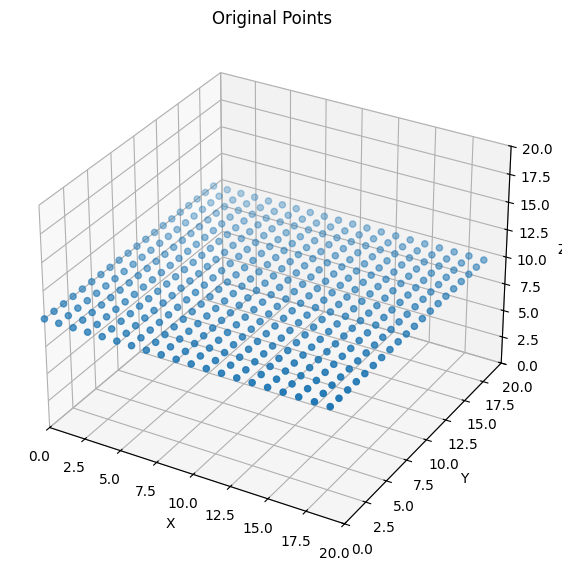

In [95]:
if plot_data:
  fig = plt.figure(figsize=(20, 15))
  ax = fig.add_subplot(2,2,1, projection='3d')
  plot_3d(ax, points[:, 0], points[:, 1], points[:, 2], "Original Points")

deformation_vector = torch.tensor([0, 0, board_size], dtype=torch.float32).to(device)
deformation_point_0 = torch.tensor(pos_points[0], dtype=torch.float32).to(device)
deformation_point_1 = torch.tensor(pos_points[1], dtype=torch.float32).to(device)

for i, noise in enumerate(noise_levels):
    # Create the input data for GPyTorch
    X = torch.stack([deformation_point_0, deformation_point_1]).to(device)
    y = torch.stack([deformation_vector, deformation_vector]).to(device)
    
    # Fixed noise likelihood - Does not work with multiple tasks
    # fixed_noise = torch.tensor([1.0, 1.0, 1.0, noise**2, noise**2, noise**2])
    # likelihood = gpytorch.likelihoods.FixedNoiseGaussianLikelihood(noise = fixed_noise, learn_additional_noise=False).to(device)

    # Multitask Likelihood - Only sets global noise for all observations and for all tasks
    likelihood = MyMultitaskGaussianLikelihood(num_tasks=3, has_global_noise=True, has_task_noise=False, has_independent_noise=True).to(device)
    likelihood.noise = 0.0001
    likelihood.independent_noise = torch.tensor([1.0, noise**2])


    model = MultitaskGPModel(X, y, likelihood).to(device)

    # Use the built-in GP model optimizer
    model.train()
    likelihood.train()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.1)
    mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

    start_time = time.time()

    training_iter = 100

    pbar = tqdm(range(training_iter), desc="Training")

    # Train the model
    for _ in pbar:
        optimizer.zero_grad()
        output = model(X)
        loss = -mll(output, y)
        loss.backward()
        optimizer.step()
        pbar.set_description(f"Loss: {loss.item():.3f}, Noise: {noise}")

  # Make predictions
    # model.to("cpu")
    # likelihood.to("cpu")
    model.eval()
    likelihood.eval()
    with torch.no_grad(), gpytorch.settings.fast_pred_var():
        predicted_distribution = likelihood(model(points_tensor))
        predicted_mean = predicted_distribution.mean
        predicted_variance = predicted_distribution.variance

    mid_time = time.time()
    new_points = points_tensor + predicted_mean

    end_time = time.time()
    execution_time_pos = mid_time - start_time
    execution_time_add = end_time - mid_time
    print(f"Execution time posterior: {execution_time_pos:.2f}s with noise: {noise}")
    print(f"Execution time adding: {execution_time_add:.2f}s with noise: {noise}")

    if plot_data:
        ax = fig.add_subplot(2,2,i+2, projection='3d')
        new_points_cpu = new_points.cpu().numpy()
        plot_3d(ax, new_points_cpu[:, 0], new_points_cpu[:, 1], new_points_cpu[:, 2], f"Deformed Points with noise {noise}")

if plot_data:
    plt.tight_layout()
    plt.show()